# P1C3 : Le Pseudo-Labeling, ou l'art de faire confiance √† son mod√®le (avec mod√©ration)

Bienvenue dans ce premier chapitre pratique ! Aujourd'hui, on s'attaque √† un classique de l'apprentissage semi-supervis√© : le **pseudo-labeling**. L'id√©e ? Si un mod√®le est suffisamment s√ªr de sa pr√©diction sur une image non √©tiquet√©e, pourquoi ne pas lui faire confiance et utiliser cette pr√©diction comme une "vraie" √©tiquette ?

> C'est un peu comme demander √† un √©l√®ve de corriger ses propres copies. Risqu√©, mais si on le guide bien, √ßa peut marcher !

**Objectifs du jour :**
1. Entra√Æner un premier mod√®le sur tr√®s peu de donn√©es.
2. Utiliser ce mod√®le pour g√©n√©rer des pseudo-labels sur des donn√©es non √©tiquet√©es.
3. Impl√©menter la boucle de pseudo-labeling pour r√©-entra√Æner le mod√®le.
4. Comprendre l'importance du **seuil de confiance** et de la **calibration**.

## 1. Pr√©paration de l'environnement et des donn√©es

On commence par les bases : importer les librairies et charger notre dataset, `DermaMNIST`. C'est un jeu de donn√©es d'images de l√©sions cutan√©es. Notre mission : les classifier correctement, m√™me avec une poign√©e d'√©tiquettes.

DermaMNIST fait partie de la famille des datasets **MedMNIST**, une collection standardis√©e de datasets d'images m√©dicales, tous au format 28x28 et organis√©s de mani√®re similaire aux c√©l√®bres datasets MNIST. L'objectif de MedMNIST est de faciliter la recherche et la comparaison de mod√®les d'apprentissage automatique sur des t√¢ches m√©dicales.

Le dataset DermaMNIST est bas√© sur le HAM10000, une large collection d'images de dermatoscopie. Il contient des images de 7 classes diff√©rentes de l√©sions cutan√©es. Son int√©r√™t p√©dagogique est majeur : il permet d'aborder des probl√®mes de classification d'images m√©dicales avec un dataset de taille raisonnable, tout en simulant des sc√©narios de faible quantit√© de donn√©es √©tiquet√©es, parfait pour explorer des techniques comme le pseudo-labeling.

Les 7 classes de l√©sions cutan√©es sont :

    0: actinic keratoses and intraepithelial carcinoma
    1: basal cell carcinoma
    2: benign keratosis-like lesions
    3: dermatofibroma
    4: melanoma
    5: melanocytic nevi
    6: vascular lesions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision import transforms
import medmnist
from medmnist import INFO, Evaluator
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# Pour la reproductibilit√©, parce qu'on est des gens s√©rieux
torch.manual_seed(42)
np.random.seed(42)

### Chargement du dataset DermaMNIST

La librairie `medmnist` nous simplifie la vie. On t√©l√©charge les donn√©es et on les pr√©pare.

In [2]:
# Nom du dataset √† charger
data_flag = 'dermamnist'
# R√©cup√®re les informations sp√©cifiques √† ce dataset depuis medmnist
info = INFO[data_flag]

# Ajout de prints pour mieux comprendre le dataset
print(f"Dataset charg√© : {data_flag}")

# Extrait le type de t√¢che (classification, r√©gression, etc.)
task = info['task']
print(f"Type de t√¢che : {task}")

# Extrait le nombre de canaux des images (3 pour RGB, 1 pour niveaux de gris)
n_channels = info['n_channels']
print(f"Nombre de canaux : {n_channels}")

# Extrait le nombre de classes pour la classification
n_classes = len(info['label'])
print(f"Nombre de classes : {n_classes}")

# R√©cup√®re la classe Python sp√©cifique pour ce dataset
DataClass = getattr(medmnist, info['python_class'])

# Transformations √† appliquer aux images :
# 1. transforms.ToTensor() : Convertit les images PIL en tensors PyTorch (scalaire entre 0 et 1)
# 2. transforms.Normalize() : Normalise les tensors avec la moyenne et l'√©cart-type sp√©cifi√©s
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]) # Normalisation standard pour les images
])

# Charge les datasets d'entra√Ænement et de test en appliquant les transformations et en t√©l√©chargeant si n√©cessaire
train_dataset = DataClass(split='train', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_transform, download=True)

print(f"Taille du jeu d'entra√Ænement : {len(train_dataset)}")
print(f"Taille du jeu de test : {len(test_dataset)}")

Dataset charg√© : dermamnist
Type de t√¢che : multi-class
Nombre de canaux : 3
Nombre de classes : 7
Taille du jeu d'entra√Ænement : 7007
Taille du jeu de test : 2005


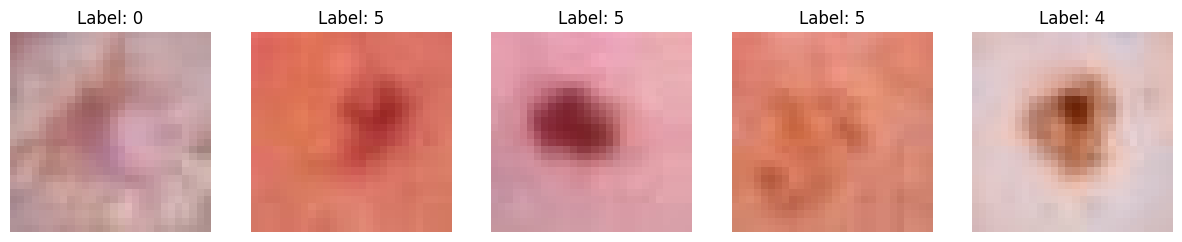

In [3]:
# Visualisation de quelques exemples
num_examples = 5
fig, axes = plt.subplots(1, num_examples, figsize=(15, 3))

for i in range(num_examples):
    # R√©cup√®re une image et son label
    image, label = train_dataset[i]
    # L'image est un tensor, on le convertit en numpy array et on le transpose pour l'affichage
    # On d√©normalise aussi l'image pour un affichage correct
    img = image.numpy().transpose(1, 2, 0) * 0.5 + 0.5
    axes[i].imshow(img.squeeze(), cmap='gray') # Use cmap='gray' for single channel images if needed
    axes[i].set_title(f"Label: {label.item()}")
    axes[i].axis('off')

plt.show()

### Cr√©ation des jeux de donn√©es : √âtiquet√© vs. Non-√©tiquet√©

C'est ici que la magie du semi-supervis√© op√®re. On va simuler une situation o√π on a tr√®s peu de donn√©es √©tiquet√©es et un grand volume de donn√©es dont on ignore la classe.

On va prendre seulement **50 images par classe** pour l'entra√Ænement √©tiquet√© (350 images au total). Le reste du jeu d'entra√Ænement sera notre vivier de donn√©es non-√©tiquet√©es.

In [4]:
# On prend tout le set d'entra√Ænement initial
all_indices = list(range(len(train_dataset)))
labels_array = np.array(train_dataset.labels).flatten()

# S√©lectionner 50 images par classe
labeled_indices = []
for c in range(n_classes):
    class_indices = np.where(labels_array == c)[0]
    selected = np.random.choice(class_indices, min(50, len(class_indices)), replace=False)
    labeled_indices.extend(selected)

# Les indices non √©tiquet√©s sont le reste
unlabeled_indices = list(set(all_indices) - set(labeled_indices))

# Cr√©ation des Subsets PyTorch
labeled_dataset = Subset(train_dataset, labeled_indices)
unlabeled_dataset = Subset(train_dataset, unlabeled_indices)

print(f"Taille du jeu de donn√©es √©tiquet√© : {len(labeled_dataset)}")
print(f"Taille du jeu de donn√©es non-√©tiquet√© : {len(unlabeled_dataset)}")
print(f"Taille du jeu de test : {len(test_dataset)}")

# DataLoaders
labeled_loader = DataLoader(dataset=labeled_dataset, batch_size=16, shuffle=True)
unlabeled_loader = DataLoader(dataset=unlabeled_dataset, batch_size=128, shuffle=False) # Pas besoin de shuffle ici
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

Taille du jeu de donn√©es √©tiquet√© : 350
Taille du jeu de donn√©es non-√©tiquet√© : 6657
Taille du jeu de test : 2005


Distribution des classes dans le 'labeled_dataset' (350 images) :

Classe 0 (actinic keratoses and intraepithelial carcinoma): 50 images
Classe 1 (basal cell carcinoma): 50 images
Classe 2 (benign keratosis-like lesions): 50 images
Classe 3 (dermatofibroma): 50 images
Classe 4 (melanoma): 50 images
Classe 5 (melanocytic nevi): 50 images
Classe 6 (vascular lesions): 50 images


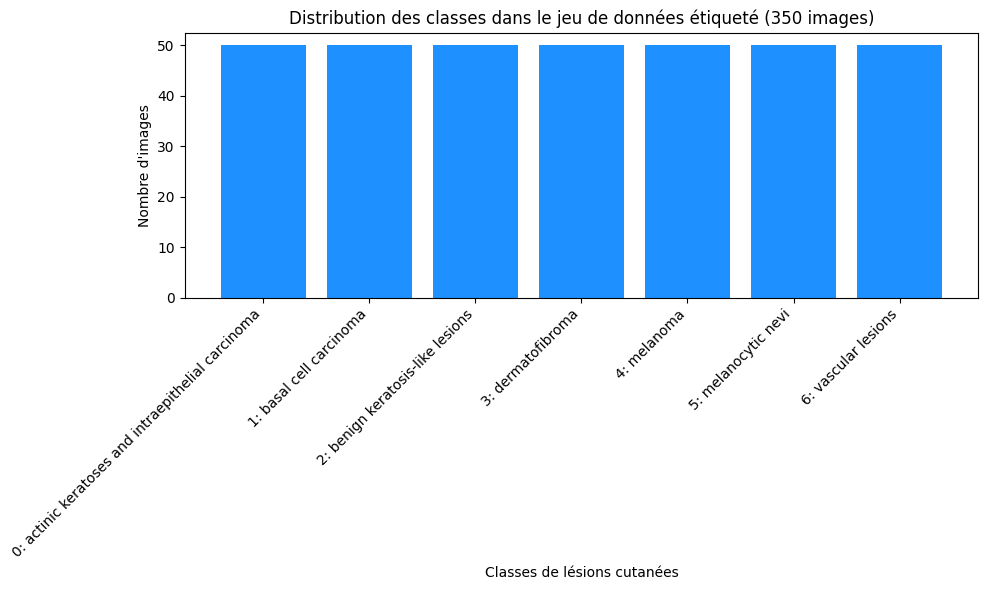

In [5]:
# Les labels du dataset complet sont dans train_dataset.labels
# On r√©cup√®re les labels correspondant aux indices de notre jeu √©tiquet√©
labels_of_labeled_set = train_dataset.labels[labeled_indices]

# Compter le nombre d'occurrences de chaque classe
class_counts = np.bincount(np.array(labels_of_labeled_set).flatten(), minlength=n_classes)
class_names = [f'{i}: {name}' for i, name in info['label'].items()]

# Afficher les comptes
print("Distribution des classes dans le 'labeled_dataset' (350 images) :\n")
for i, count in enumerate(class_counts):
    # R√©cup√©rer le nom complet de la classe
    full_class_name = info['label'][str(i)]
    print(f"Classe {i} ({full_class_name}): {count} images")

# Cr√©er un graphique √† barres pour visualiser la distribution
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts, color='dodgerblue')
plt.xlabel('Classes de l√©sions cutan√©es')
plt.ylabel("Nombre d'images")
plt.title("Distribution des classes dans le jeu de donn√©es √©tiquet√© (350 images)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 2. Le Mod√®le de Base (Supervis√©)

On va d'abord entra√Æner un mod√®le simple (un petit CNN) uniquement sur nos 350 images √©tiquet√©es. On s'attend √† une performance... modeste. C'est notre point de d√©part.

In [6]:
# D√©finition d'un petit CNN (vous pouvez l'am√©liorer !)
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7 * 7 * 32, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

# D√©finir le device (√† mettre au d√©but de votre code si ce n'est pas d√©j√† fait)
device = torch.device("cpu")

# On instancie la loss (sans poids car dataset √©quilibr√©)
criterion = nn.CrossEntropyLoss()

# On d√©place aussi le mod√®le sur le device
model = SimpleCNN(in_channels=n_channels, num_classes=n_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Boucle d'entra√Ænement et d'√©valuation

Rien de nouveau sous le soleil ici, c'est une boucle d'entra√Ænement PyTorch standard. On va l'encapsuler dans une fonction pour la r√©utiliser.

In [7]:
def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, epochs=10):
    """Entra√Æne et √©value un mod√®le."""
    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # √âvaluation
    model.eval()
    y_true = torch.tensor([]).to(device)
    y_score_logits = torch.tensor([]).to(device)  # Pour stocker les logits (pour Evaluator)
    y_score_preds = torch.tensor([]).to(device)  # Pour stocker les pr√©dictions (pour f1_score)
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            y_true = torch.cat((y_true, labels), 0)
            y_score_logits = torch.cat((y_score_logits, outputs), 0)
            # Convertir les logits en pr√©dictions de classe
            preds = torch.argmax(outputs, dim=1)
            y_score_preds = torch.cat((y_score_preds, preds), 0)

    y_true = y_true.squeeze().cpu().numpy()
    y_score_logits = y_score_logits.detach().cpu().numpy()
    y_score_preds = y_score_preds.detach().cpu().numpy()
    
    # √âvaluation avec medmnist Evaluator (utilise les logits)
    evaluator = Evaluator(data_flag, 'test')
    metrics = evaluator.evaluate(y_score_logits)
    
    # Calcul du F1 score avec les pr√©dictions de classe
    f1 = f1_score(y_true, y_score_preds, average='macro')

    print(f'AUC: {metrics[0]:.3f}, Accuracy: {metrics[1]:.3f}, F1: {f1:.3f}')
    return (metrics[0], metrics[1], f1)

print("Entra√Ænement du mod√®le de base sur 350 images √©tiquet√©es...")
baseline_metrics = train_and_evaluate(model, labeled_loader, test_loader, optimizer, criterion)

Entra√Ænement du mod√®le de base sur 350 images √©tiquet√©es...
AUC: 0.838, Accuracy: 0.490, F1: 0.315


## 3. Le Pseudo-Labeling √† la rescousse !

Le score de base est probablement... bof. C'est normal !
Maintenant, on va mettre en place la boucle de pseudo-labeling.

**Le principe :**
1. **Pr√©dire** sur les donn√©es non √©tiquet√©es.
2. **S√©lectionner** les pr√©dictions o√π le mod√®le est le plus confiant (au-dessus d'un certain `seuil`).
3. **Ajouter** ces pr√©dictions (images + pseudo-labels) au jeu d'entra√Ænement √©tiquet√©.
4. **R√©-entra√Æner** le mod√®le sur ce nouveau jeu de donn√©es augment√©.
5. R√©p√©ter !

G√©n√©ration des pseudo-labels :
1. Parcourir le `unlabeled_loader`.
2. Obtenir les pr√©dictions du mod√®le.
3. Appliquer un `softmax` pour avoir des probabilit√©s.
4. Identifier la probabilit√© maximale (`probs`) et la classe pr√©dite (`preds`) pour chaque image.
5. Ne garder que les images o√π `probs` est sup√©rieur au `threshold`.
6. Retourner les indices de ces images et leurs pseudo-labels.

In [8]:
def get_pseudo_labels(model, unlabeled_loader, threshold=0.95):
    """G√©n√®re des pseudo-labels pour les donn√©es o√π le mod√®le est confiant."""
    model.eval()
    pseudo_labeled_indices = []
    pseudo_labels = []

    with torch.no_grad():
        for i, (images, _) in enumerate(unlabeled_loader):
            # D√©placer les images sur le m√™me appareil que le mod√®le (GPU si disponible)
            images = images.to(next(model.parameters()).device)

            # 1. Obtenir les pr√©dictions (logits)
            outputs = model(images)

            # 2. Calculer les probabilit√©s (softmax)
            probabilities = torch.softmax(outputs, dim=1)

            # 3. Obtenir la proba max et la classe pr√©dite
            max_probs, predicted_classes = torch.max(probabilities, dim=1)

            # 4. Filtrer selon le seuil
            confident_mask = max_probs > threshold

            # 5. R√©cup√©rer les indices et les labels
            # Les indices dans le DataLoader ne correspondent pas aux indices dans le dataset original
            # Il faut donc calculer les indices r√©els dans le unlabeled_dataset
            batch_start_index = i * unlabeled_loader.batch_size
            original_indices_in_unlabeled_dataset = torch.arange(batch_start_index, batch_start_index + images.size(0))

            # On utilise les indices originaux dans le unlabeled_dataset pour acc√©der aux indices dans le train_dataset complet
            original_indices = [unlabeled_loader.dataset.indices[j] for j in original_indices_in_unlabeled_dataset[confident_mask]]

            confident_labels = predicted_classes[confident_mask]


            pseudo_labeled_indices.extend(original_indices)
            pseudo_labels.extend(confident_labels.tolist())

    print(f"Nombre d'images pour lesquelles le mod√®le est confiant (> {threshold:.2f}) : {len(pseudo_labeled_indices)}")
    return pseudo_labeled_indices, pseudo_labels

### La grande boucle de pseudo-labeling

Maintenant, on assemble tout. On va faire plusieurs it√©rations de pseudo-labeling.

In [9]:
# On r√©initialise le mod√®le et l'optimiseur
ssl_model = SimpleCNN(in_channels=n_channels, num_classes=n_classes).to(device)
ssl_optimizer = torch.optim.Adam(ssl_model.parameters(), lr=0.001)

# On commence avec le jeu de donn√©es √©tiquet√© de base
current_labeled_indices = list(labeled_indices)

for iteration in range(5): # 5 it√©rations de pseudo-labeling
    print(f'--- It√©ration {iteration+1} ---')

    # On cr√©e le dataset d'entra√Ænement actuel
    iter_dataset = Subset(train_dataset, current_labeled_indices)
    iter_loader = DataLoader(iter_dataset, batch_size=32, shuffle=True)

    # 1. Entra√Æner le mod√®le
    print(f'Entra√Ænement sur {len(iter_dataset)} images...')
    pseudo_label_auc, pseudo_label_acc, pseudo_label_f1 = train_and_evaluate(ssl_model, iter_loader, test_loader, ssl_optimizer, criterion, epochs=5)

    # 2. G√©n√©rer des pseudo-labels
    print('G√©n√©ration de pseudo-labels...')
    pseudo_indices, pseudo_labels = get_pseudo_labels(ssl_model, unlabeled_loader, threshold=0.9)
    print(f'{len(pseudo_indices)} nouveaux pseudo-labels ajout√©s.')

    # 3. Mettre √† jour le dataset d'entra√Ænement
    temp_dataset = train_dataset
    for idx, label in zip(pseudo_indices, pseudo_labels):
        # On ne modifie que les labels des images qu'on a pseudo-√©tiquet√©es
        if idx not in current_labeled_indices: # Pour ne pas √©craser les vrais labels
            temp_dataset.labels[idx] = label
            current_labeled_indices.append(idx)

    if len(pseudo_indices) == 0:
        print("Plus de pseudo-labels trouv√©s, on arr√™te l√† !")
        break

--- It√©ration 1 ---
Entra√Ænement sur 350 images...
AUC: 0.807, Accuracy: 0.450, F1: 0.275
G√©n√©ration de pseudo-labels...
Nombre d'images pour lesquelles le mod√®le est confiant (> 0.90) : 92
92 nouveaux pseudo-labels ajout√©s.
--- It√©ration 2 ---
Entra√Ænement sur 442 images...
AUC: 0.826, Accuracy: 0.465, F1: 0.283
G√©n√©ration de pseudo-labels...
Nombre d'images pour lesquelles le mod√®le est confiant (> 0.90) : 964
964 nouveaux pseudo-labels ajout√©s.
--- It√©ration 3 ---
Entra√Ænement sur 1314 images...
AUC: 0.831, Accuracy: 0.578, F1: 0.367
G√©n√©ration de pseudo-labels...
Nombre d'images pour lesquelles le mod√®le est confiant (> 0.90) : 2016
2016 nouveaux pseudo-labels ajout√©s.
--- It√©ration 4 ---
Entra√Ænement sur 2384 images...
AUC: 0.839, Accuracy: 0.528, F1: 0.306
G√©n√©ration de pseudo-labels...
Nombre d'images pour lesquelles le mod√®le est confiant (> 0.90) : 2964
2964 nouveaux pseudo-labels ajout√©s.
--- It√©ration 5 ---
Entra√Ænement sur 3353 images...
AUC: 0.838

In [10]:
# Chemin o√π sauvegarder le mod√®le
model_save_path = 'dermamnist_ssl_model.pth'

# On sauvegarde uniquement les poids du mod√®le (c'est la meilleure pratique)
torch.save(ssl_model.state_dict(), model_save_path)

print(f"Mod√®le sauvegard√© avec succ√®s dans : {model_save_path}")

Mod√®le sauvegard√© avec succ√®s dans : dermamnist_ssl_model.pth


## 4. Analyse et Questions de R√©flexion

A-t-on am√©lior√© le score ? Normalement, oui ! Mais √† quel prix ?

**Questions pour aller plus loin :**
1. **L'impact du seuil** : Que se passe-t-il si vous baissez le seuil √† 0.8 ? Et si vous l'augmentez √† 0.99 ? Un seuil bas risque d'introduire du bruit (mauvais labels), un seuil haut risque de ne s√©lectionner que les exemples "faciles".
2. **La d√©rive de confirmation** : Le mod√®le devient de plus en plus confiant dans ses propres erreurs. Comment pourrait-on limiter ce ph√©nom√®ne ? (Indice : calibration, r√©gularisation...)
3. **Calibration du mod√®le** : Un mod√®le bien calibr√© donne des probabilit√©s qui refl√®tent sa confiance r√©elle. Un score de 0.8 devrait signifier "correct dans 80% des cas". Est-ce le cas ici ? Comment le v√©rifier ? (Indice : ECE, Brier score, diagrammes de fiabilit√©). C'est un excellent sujet pour le chapitre 7 !

> **Le mot de la fin :** Le pseudo-labeling est une technique simple mais puissante. Son succ√®s d√©pend enti√®rement de la qualit√© des pseudo-labels. Dans les prochains chapitres, on verra des m√©thodes plus robustes pour s'assurer de ne pas propager les erreurs !

# P1C4 : La Propagation de Labels, ou l'art de juger une image par ses voisins 

Bienvenue dans cette nouvelle exp√©rience ! Dans le chapitre pr√©c√©dent sur le pseudo-labeling, on a vu que notre mod√®le pouvait devenir un peu trop s√ªr de lui et finir par tourner en rond, en se confortant dans ses propres erreurs. C'est le fameux **biais de confirmation** ! 

> C'est comme ne parler qu'√† des gens qui sont d'accord avec vous : on n'apprend plus rien de nouveau.

**Nos objectifs de super-d√©tective :**
1.  **Recruter un expert** : Charger le mod√®le qu'on a p√©niblement entra√Æn√© au pseudo-labeling pour qu'il nous aide.
2.  **Cartographier le terrain** : Utiliser cet expert pour extraire l'ADN de chaque image (ses *embeddings*).
3.  **Tisser une toile** : Construire un graphe o√π chaque image est un n≈ìud, connect√© √† ses plus proches voisins.
4.  **Laisser la magie op√©rer** : Regarder les √©tiquettes de nos 350 images connues se propager √† travers la toile pour deviner les autres.
5.  **Comparer les r√©sultats** : Est-ce que cette m√©thode de 'sagesse des foules' est meilleure que de faire confiance √† un seul mod√®le ? Le suspense est √† son comble !

## 1. Pr√©paration du terrain : On reprend (presque) les m√™mes !

On commence par importer nos outils et pr√©parer notre jeu de donn√©es `DermaMNIST`. On va recr√©er notre sc√©nario de d√©part : 350 images √©tiquet√©es (50 par classe) et des milliers d'autres qui attendent d'√™tre identifi√©es.

In [11]:
# Chargement des donn√©es
data_flag = 'dermamnist'
info = INFO[data_flag]
n_classes = len(info['label'])
n_channels = info['n_channels']
DataClass = getattr(medmnist, info['python_class'])

# Transformations standard
data_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[.5], std=[.5])])

# On charge le jeu d'entra√Ænement complet et le jeu de test
train_dataset = DataClass(split='train', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_transform, download=True)

# On recr√©e notre situation de d√©part : 50 images par classe √©tiquet√©es, et le reste en attente
all_indices = list(range(len(train_dataset)))
labels_array = np.array(train_dataset.labels).flatten()

# S√©lectionner 50 images par classe
labeled_indices = []
for c in range(n_classes):
    class_indices = np.where(labels_array == c)[0]
    selected = np.random.choice(class_indices, min(50, len(class_indices)), replace=False)
    labeled_indices.extend(selected)

# Les indices non √©tiquet√©s sont le reste
unlabeled_indices = list(set(all_indices) - set(labeled_indices))

print(f'Taille totale du jeu d\'entra√Ænement : {len(train_dataset)} images')
print(f'Donn√©es √©tiquet√©es (nos indics ) : {len(labeled_indices)} images')
print(f'Donn√©es non-√©tiquet√©es (les myst√®res √† r√©soudre ) : {len(unlabeled_indices)} images')

Taille totale du jeu d'entra√Ænement : 7007 images
Donn√©es √©tiquet√©es (nos indics ) : 350 images
Donn√©es non-√©tiquet√©es (les myst√®res √† r√©soudre ) : 6657 images


## 2. Recruter notre expert : le mod√®le du chapitre pr√©c√©dent

Pour que la propagation de labels fonctionne, on a besoin de 'sentir' la similarit√© entre les images. Utiliser les pixels bruts serait un d√©sastre ! 

On va donc faire appel √† un sp√©cialiste : le `SimpleCNN` qu'on a entra√Æn√© dans le notebook `P1C3`. M√™me s'il n'√©tait pas parfait, il a d√©j√† appris √† extraire des caract√©ristiques pertinentes des images de peau. On va lui demander de nous fournir les **embeddings** : une sorte de r√©sum√© num√©rique, ou d'ADN, pour chaque image.

In [12]:
# On d√©finit l'architecture de notre CNN. 
# ATTENTION : Elle doit √™tre IDENTIQUE √† celle du mod√®le sauvegard√© !
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # Pour correspondre exactement au mod√®le de P1C3
        self.fc = nn.Linear(7 * 7 * 32, num_classes)

    def forward(self, x, return_features=False):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        if return_features:
            return out  # Retourne les features avant la classification (dimension 1568)
        out = self.fc(out)
        return out

model = SimpleCNN(in_channels=n_channels, num_classes=n_classes)
model_path = 'dermamnist_ssl_model.pth'

try:
    state_dict = torch.load(model_path, map_location=device)
    # Les noms de couches correspondent exactement, on charge tout
    model.load_state_dict(state_dict)
    print(f'‚úÖ Mod√®le charg√© depuis : {model_path}')
except FileNotFoundError:
    print(f'üö® Oups ! Le fichier {model_path} est introuvable.')
    print('Veuillez d\'abord ex√©cuter le notebook P1C3 pour entra√Æner et sauvegarder le mod√®le.')
    raise

# On passe le mod√®le sur le bon appareil et en mode √©valuation
model.to(device)
model.eval()

‚úÖ Mod√®le charg√© depuis : dermamnist_ssl_model.pth


SimpleCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=7, bias=True)
)

## 3. Extraction des 'Coordonn√©es GPS' (Embeddings) 

Maintenant que notre expert est pr√™t, on va le faire passer sur **toutes** les images de notre jeu d'entra√Ænement (√©tiquet√©es ou non) pour obtenir leurs fameux embeddings. C'est comme cr√©er une carte d'identit√© pour chaque image.

In [13]:
def get_embeddings(model, dataset, device):
    """Extrait les embeddings d'un dataset en utilisant un mod√®le."""
    model.eval()
    embeddings = []
    loader = DataLoader(dataset, batch_size=256, shuffle=False, num_workers=2)
    
    with torch.no_grad():
        for images, _ in tqdm(loader, desc='Extraction des embeddings'):
            images = images.to(device)
            feats = model(images, return_features=True)
            embeddings.append(feats.cpu().numpy())
            
    return np.vstack(embeddings)

# On extrait les embeddings en utilisant notre mod√®le
all_embeddings = get_embeddings(model, train_dataset, device)

print(f'\nExtraction termin√©e ! On a obtenu {all_embeddings.shape[0]} embeddings de dimension {all_embeddings.shape[1]}.')

Extraction des embeddings: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 28/28 [00:00<00:00, 31.23it/s]


Extraction termin√©e ! On a obtenu 7007 embeddings de dimension 1568.


## 4. La Propagation des Rumeurs (de Labels) 

C'est le moment que vous attendiez tous ! On va utiliser l'algorithme `LabelSpreading` de scikit-learn.

Comment √ßa marche ?
1. Il prend tous nos embeddings et construit un graphe de similarit√© (notre fameuse toile ).
2. On lui donne les 350 √©tiquettes qu'on conna√Æt. Pour les autres, on met une √©tiquette sp√©ciale : `-1` (qui veut dire 'Je ne sais pas').
3. L'algorithme va alors 'propager' l'influence des √©tiquettes connues √† leurs voisins, puis aux voisins de leurs voisins, jusqu'√† ce que chaque image ait une √©tiquette probable.

C'est un processus d√©mocratique o√π chaque image est influenc√©e par sa communaut√© !

In [14]:
# On pr√©pare le tableau des labels pour l'algorithme
labels_for_spreading = np.full(len(train_dataset), -1, dtype=int)
labels_for_spreading[labeled_indices] = labels_array[labeled_indices]

print(f'Verification : {np.sum(labels_for_spreading != -1)} labels sont connus. Parfait !')

# On instancie le mod√®le LabelSpreading
label_spreading_model = LabelSpreading(kernel='knn', n_neighbors=10, n_jobs=-1)

print('Propagation des labels en cours... C\'est le moment d\'aller prendre un caf√© ')
label_spreading_model.fit(all_embeddings, labels_for_spreading)
print('Propagation termin√©e ! Voyons ce qu\'on a trouv√©.')

# On r√©cup√®re les labels pr√©dits pour l'ensemble du dataset
predicted_labels = label_spreading_model.transduction_

# On r√©cup√®re les probabilit√©s pr√©dites pour l'AUC
predicted_probs = label_spreading_model.predict_proba(all_embeddings)

Verification : 350 labels sont connus. Parfait !
Propagation des labels en cours... C'est le moment d'aller prendre un caf√© 
Propagation termin√©e ! Voyons ce qu'on a trouv√©.


## 5. Le Verdict : Alors, √ßa a march√© ? 

Le mod√®le a rempli tous les trous et a attribu√© une √©tiquette √† chaque image. Mais est-ce que ces pr√©dictions sont bonnes?

Pour le savoir, on va comparer les √©tiquettes pr√©dites pour les donn√©es *initialement non-√©tiquet√©es* avec leurs vraies √©tiquettes (qu'on avait cach√©es). C'est l'heure de v√©rit√© !

--- R√©sultats de la Propagation de Labels ---
Accuracy sur les 6657 images myst√®res : 0.440
AUC (OvR) : 0.755
F1-score (macro) : 0.244


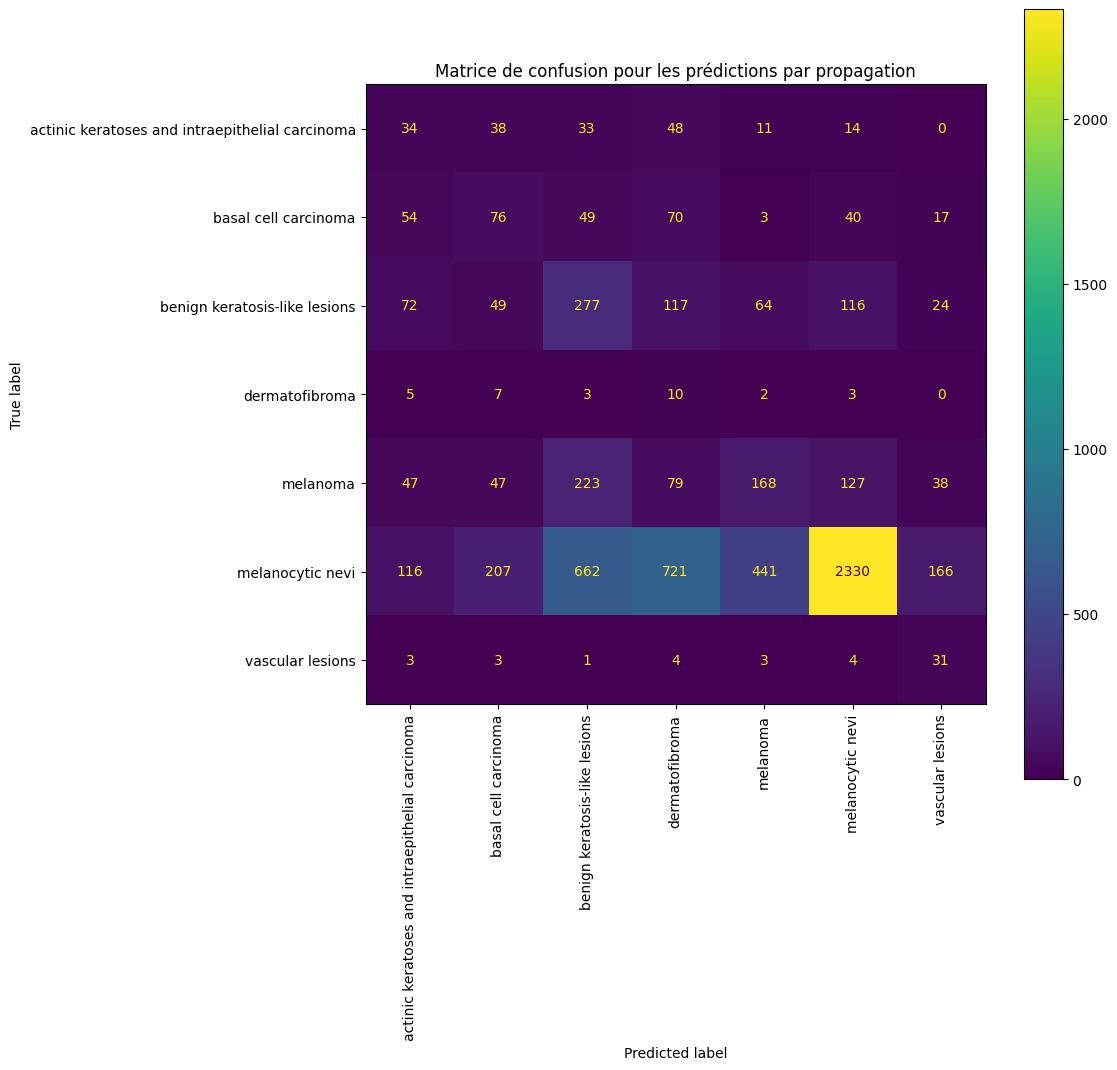

In [15]:
# On prend les labels pr√©dits et probabilit√©s UNIQUEMENT pour les donn√©es non √©tiquet√©es
unlabeled_predicted_labels = predicted_labels[unlabeled_indices]
unlabeled_predicted_probs = predicted_probs[unlabeled_indices]
unlabeled_true_labels = labels_array[unlabeled_indices]

# On calcule les m√©triques de performance
accuracy = accuracy_score(unlabeled_true_labels, unlabeled_predicted_labels)
propag_auc = roc_auc_score(unlabeled_true_labels, unlabeled_predicted_probs, multi_class='ovr')  # Utiliser 'ovr' pour multiclasse
f1 = f1_score(unlabeled_true_labels, unlabeled_predicted_labels, average='macro')

print('--- R√©sultats de la Propagation de Labels ---')
print(f'Accuracy sur les {len(unlabeled_indices)} images myst√®res : {accuracy:.3f}')
print(f'AUC (OvR) : {propag_auc:.3f}')
print(f'F1-score (macro) : {f1:.3f}')

# Rappel : le pseudo-labeling stagnait autour de 0.65 d'accuracy.
# Si on est au-dessus, c'est une victoire ! 

# On affiche la matrice de confusion pour voir o√π le mod√®le se trompe
cm = confusion_matrix(unlabeled_true_labels, unlabeled_predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(info['label'].values()))

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation='vertical')
plt.title('Matrice de confusion pour les pr√©dictions par propagation')
plt.show()

In [16]:
from torch.utils.data import Dataset

# Cr√©er un dataset personnalis√© avec les labels propag√©s
class PropagatedDataset(Dataset):
    def __init__(self, dataset, labels):
        self.dataset = dataset
        self.labels = labels

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]  # Ignore les labels d'origine, img est d√©j√† un tenseur transform√©
        label = self.labels[idx]
        return img, label

# Cr√©er le nouveau dataset avec les labels propag√©s
train_dataset_propagated = PropagatedDataset(train_dataset, predicted_labels)

# Cr√©er un DataLoader pour l'entra√Ænement
train_loader_propagated = DataLoader(train_dataset_propagated, batch_size=32, shuffle=True, num_workers=2)

In [17]:
# D√©finir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Entra√Ænement du mod√®le de base sur images √©tiquet√©es avec labels propag√©s...")
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)
metrics = train_and_evaluate(model, train_loader_propagated, test_loader, optimizer, criterion)

print('Entra√Ænement termin√© !')

Entra√Ænement du mod√®le de base sur images √©tiquet√©es avec labels propag√©s...
AUC: 0.520, Accuracy: 0.310, F1: 0.309
Entra√Ænement termin√© !


## 6. Conclusion et Questions pour la suite 

Normalement, vous devriez voir une **nette am√©lioration** par rapport au pseudo-labeling ! L'accuracy et le F1-score devraient √™tre plus √©lev√©s, et les graphiques t-SNE devraient montrer que les clusters de couleurs pr√©dits ressemblent beaucoup plus √† la v√©rit√© terrain.

La propagation de labels est puissante car elle exploite la **structure globale** des donn√©es, au lieu de se fier aux pr√©dictions isol√©es et parfois trop confiantes d'un seul mod√®le. 

**Mais on peut encore faire mieux ! Voici quelques questions pour ouvrir sur les prochains chapitres :**

1. **La qualit√© des embeddings** : On a utilis√© un petit CNN entra√Æn√© sur peu de donn√©es. Que se passerait-il si on utilisait un mod√®le beaucoup plus puissant, comme un **ResNet pr√©-entra√Æn√© sur des millions d'images (ImageNet)**, pour extraire nos embeddings ? La carte serait-elle plus pr√©cise ?

2. **Et si on cr√©ait de fausses images ?** On manque de donn√©es √©tiquet√©es. Et si, au lieu de deviner des labels, on demandait √† une IA de nous **g√©n√©rer de nouvelles images** de l√©sions cutan√©es qui ressemblent aux vraies ? C'est le monde fascinant des **GANs (Generative Adversarial Networks)** que nous explorerons bient√¥t !

3. **Le meilleur des deux mondes ?** Peut-on combiner le pseudo-labeling et les approches par graphe ? (Indice : oui, et ce sont souvent les m√©thodes les plus performantes !)

# P1C5 : Les Semi-Supervised GANs, ou l'art de g√©n√©rer pour mieux classer

Bienvenue dans ce chapitre d√©di√© aux **Semi-Supervised Generative Adversarial Networks (SGANs)** ! Apr√®s avoir explor√© le pseudo-labeling (qui se fie aux pr√©dictions confiantes du mod√®le) et la propagation de labels (qui exploite les similarit√©s entre images via des graphes), on passe √† une approche plus 'cr√©ative' : utiliser des r√©seaux adversariaux pour g√©n√©rer de nouvelles donn√©es et am√©liorer la classification.

> Imaginez deux agents en comp√©tition : l'un (le g√©n√©rateur) cr√©e de fausses images pour tromper l'autre (le discriminateur), qui doit non seulement d√©tecter les faux, mais aussi classer les vraies images. Cette 'bataille' permet d'apprendre des repr√©sentations riches, m√™me avec peu de labels !

Les SGANs √©tendent les GANs classiques au semi-supervis√© : le discriminateur pr√©dit √† la fois 'vrai/faux' et la classe pour les images vraies. Cela permet d'utiliser les donn√©es non √©tiquet√©es pour renforcer l'apprentissage non supervis√© (vrai vs faux), et les √©tiquet√©es pour la supervision.

**Pourquoi SGAN ?** Dans les contextes comme DermaMNIST, o√π les labels sont rares et co√ªteux (besoin d'experts m√©dicaux), g√©n√©rer de donn√©es vari√©es aide le mod√®le √† mieux g√©n√©raliser sans ajouter de bruit comme dans le pseudo-labeling.

**Compr√©hension cl√© de la strat√©gie SGAN :**
- Pour les **donn√©es √©tiquet√©es** : On corrige le discriminateur (D) pour pr√©dire la bonne classe (0 √† 6) avec une perte supervis√©e, car on conna√Æt la v√©rit√©.
- Pour les **donn√©es non √©tiquet√©es** : On corrige D pour les classer comme 'r√©elles' (somme des probabilit√©s des classes 0 √† 6 √©lev√©e), sans pr√©ciser la classe exacte. C'est une correction 'binaire' : si D les place entre 0 et 6, c'est bien ; si en 7 ('faux'), c'est mal, car ce sont des images r√©elles.
- Pour les **images g√©n√©r√©es** (fausses) : On corrige D pour les classer comme 'fausses' (classe 7). Si D les place en 0 √† 6, c'est mal ; l'objectif est de maximiser la probabilit√© de la classe 7.
- Le **g√©n√©rateur (G)** veut l'inverse : tromper D en faisant passer ses fausses images pour r√©elles (probabilit√©s √©lev√©es en 0 √† 6).

**Objectifs p√©dagogiques :**
1. üß† Comprendre les GANs et leur adaptation au semi-supervis√©.
2. üõ†Ô∏è Impl√©menter un G√©n√©rateur et un Discriminateur simples.
3. ‚öîÔ∏è Mettre en place la boucle d'entra√Ænement adversariale.
4. üìä √âvaluer le Discriminateur comme classificateur et comparer aux m√©thodes pr√©c√©dentes.
5. üé® Visualiser les images g√©n√©r√©es pour voir ce que le mod√®le 'imagine'.

On r√©utilise notre setup de DermaMNIST avec 350 images √©tiquet√©es (50 par classe). Pr√™ts √† lancer la d√©mo ?

## 1. Pr√©paration de l'environnement et des donn√©es

On r√©utilise le code de chargement de DermaMNIST des chapitres pr√©c√©dents. Si vous avez saut√© les √©tapes, ex√©cutez d'abord P1C3 ou P1C4 pour avoir les variables comme `train_dataset`, `labeled_indices`, etc. Ici, on assume qu'elles sont d√©finies.

Rappel de la strat√©gie SGAN : Les donn√©es √©tiquet√©es servent √† la perte supervis√©e (correction pr√©cise sur la classe connue), les non √©tiquet√©es √† la perte non supervis√©e (correction pour 'r√©el', i.e. classes 0-6), et les g√©n√©r√©es √† renforcer la d√©tection des faux (classe 7).

In [18]:
# Loaders pour SGAN (batch_size plus petit pour stabilit√©)
sgan_labeled_loader = DataLoader(labeled_dataset, batch_size=64, shuffle=True)
sgan_unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## 2. D√©finition des r√©seaux : G√©n√©rateur et Discriminateur

Le **G√©n√©rateur (G)** prend du bruit al√©atoire (vecteur de dimension 100) et produit des images 28x28x3.

Le **Discriminateur (D)** est une variante de notre SimpleCNN : il sort `n_classes + 1` logits (les n_classes premi√®res pour les classes r√©elles, la derni√®re pour 'faux').

Rappel : Lors de l'entra√Ænement, D sera corrig√© diff√©remment selon le type d'image :
- √âtiquet√©es : Pr√©dire la classe exacte (0-6).
- Non √©tiquet√©es : Pr√©dire 'r√©el' (somme probs 0-6 √©lev√©e).
- G√©n√©r√©es : Pr√©dire 'faux' (prob 7 √©lev√©e).

In [19]:
# Dimension du bruit
z_dim = 100

class Generator(nn.Module):
    def __init__(self, z_dim=z_dim, img_channels=3, img_size=28):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, img_size * img_size * img_channels),
            nn.Tanh()  # Sorties entre -1 et 1
        )
        self.img_size = img_size
        self.img_channels = img_channels

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), self.img_channels, self.img_size, self.img_size)
        return img

class Discriminator(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7 * 7 * 32, num_classes + 1)  # +1 pour faux

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Instanciation
G = Generator().to(device)
D = Discriminator(n_channels, n_classes).to(device)

# Optimiseurs
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.002, betas=(0.5, 0.999))

print('R√©seaux SGAN pr√™ts pour la d√©mo !')

R√©seaux SGAN pr√™ts pour la d√©mo !


## 3. La boucle d'entra√Ænement adversariale

Lheart des GANs : une boucle o√π D et G s'affrontent.

Rappel de la strat√©gie :
- **Pour D sur √©tiquet√©es** : Perte supervis√©e pour pr√©dire la bonne classe (0-6).
- **Pour D sur non √©tiquet√©es** : Perte pour pr√©dire 'r√©el' (somme probs 0-6 √©lev√©e).
- **Pour D sur g√©n√©r√©es** : Perte pour pr√©dire 'faux' (prob 7 √©lev√©e).
- **Pour G** : Perte pour tromper D (faire passer les g√©n√©r√©es pour r√©elles, somme probs 0-6 √©lev√©e).

L'entra√Ænement est altern√©. Observez les pertes pour voir l'√©quilibre.

Entra√Ænement SGAN: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [00:42<00:00,  2.33it/s]


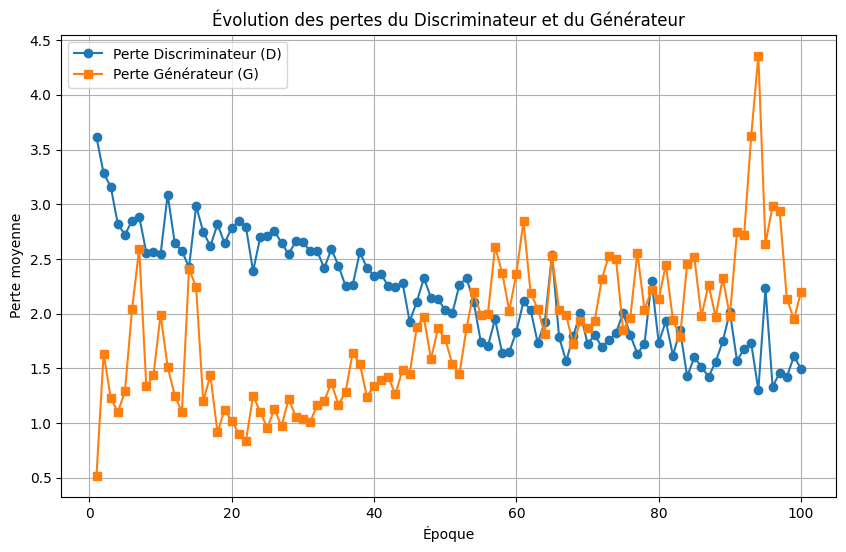

In [20]:
import matplotlib.pyplot as plt

num_epochs = 100  # Ajustez pour la d√©mo (plus = mieux, mais plus long)
supervised_criterion = nn.CrossEntropyLoss()

# Listes pour stocker les pertes moyennes par √©poque
epoch_d_losses = []
epoch_g_losses = []

for epoch in tqdm(range(num_epochs), desc='Entra√Ænement SGAN'):
    D.train()
    G.train()
    d_losses = []
    g_losses = []

    # It√©rateurs pour √©quilibrer les batches
    labeled_iter = iter(sgan_labeled_loader)
    unlabeled_iter = iter(sgan_unlabeled_loader)

    num_batches = min(len(sgan_labeled_loader), len(sgan_unlabeled_loader))
    for batch_idx in range(num_batches):
        # Donn√©es √©tiquet√©es
        try:
            labeled_imgs, labels = next(labeled_iter)
        except StopIteration:
            labeled_iter = iter(sgan_labeled_loader)
            labeled_imgs, labels = next(labeled_iter)
        labeled_imgs = labeled_imgs.to(device)
        labels = labels.squeeze().long().to(device)

        # Donn√©es non √©tiquet√©es
        try:
            unlabeled_imgs, _ = next(unlabeled_iter)
        except StopIteration:
            unlabeled_iter = iter(sgan_unlabeled_loader)
            unlabeled_imgs, _ = next(unlabeled_iter)
        unlabeled_imgs = unlabeled_imgs.to(device)
        batch_size = unlabeled_imgs.size(0)

        # G√©n√©rer fausses images
        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = G(z)

        # --- Entra√Æner D ---
        d_optimizer.zero_grad()

        # Supervis√© sur r√©elles √©tiquet√©es : corriger pour la bonne classe (0-6)
        real_labeled_logits = D(labeled_imgs)
        d_sup_loss = supervised_criterion(real_labeled_logits[:, :n_classes], labels)

        # Non supervis√© sur r√©elles non √©tiquet√©es : corriger pour 'r√©el' (somme probs 0-6 √©lev√©e)
        real_unlabeled_logits = D(unlabeled_imgs)
        real_probs = torch.softmax(real_unlabeled_logits, dim=1)[:, :n_classes].sum(1)
        d_real_unsup_loss = -torch.log(real_probs + 1e-10).mean()

        # Non supervis√© sur fausses : corriger pour 'faux' (prob 7 √©lev√©e)
        fake_logits = D(fake_imgs.detach())
        fake_probs = torch.softmax(fake_logits, dim=1)[:, n_classes]
        d_fake_unsup_loss = -torch.log(fake_probs + 1e-10).mean()

        d_loss = d_sup_loss + d_real_unsup_loss + d_fake_unsup_loss
        d_loss.backward()
        d_optimizer.step()
        d_losses.append(d_loss.item())

        # --- Entra√Æner G : corriger pour tromper D (somme probs 0-6 √©lev√©e pour fausses) ---
        g_optimizer.zero_grad()

        fake_logits_g = D(fake_imgs)
        g_fake_probs = torch.softmax(fake_logits_g, dim=1)[:, :n_classes].sum(1)
        g_loss = -torch.log(g_fake_probs + 1e-10).mean()

        g_loss.backward()
        g_optimizer.step()
        g_losses.append(g_loss.item())

    # Calculer et stocker les pertes moyennes par √©poque
    epoch_d_losses.append(np.mean(d_losses))
    epoch_g_losses.append(np.mean(g_losses))

# Afficher le graphique des pertes
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_d_losses, label='Perte Discriminateur (D)', marker='o')
plt.plot(range(1, num_epochs + 1), epoch_g_losses, label='Perte G√©n√©rateur (G)', marker='s')
plt.xlabel('√âpoque')
plt.ylabel('Perte moyenne')
plt.title('√âvolution des pertes du Discriminateur et du G√©n√©rateur')
plt.legend()
plt.grid(True)
plt.show()

## 4. √âvaluation et comparaison

Utilisons le Discriminateur comme classificateur : on prend l'argmax sur les n_classes premi√®res sorties.

Rappel : Gr√¢ce √† la strat√©gie, D a √©t√© corrig√© sur les √©tiquet√©es (classes exactes), non √©tiquet√©es ('r√©el' vs 'faux'), et g√©n√©r√©es (d√©tection des faux). Cela devrait am√©liorer sa performance en classification.

Comparons avec les baselines des chapitres pr√©c√©dents (remplacez les placeholders par vos r√©sultats r√©els).

In [21]:
def evaluate_sgan(model, test_loader, n_classes):
    model.eval()
    y_true = []
    y_pred = []
    y_score_probs = []  # Pour stocker les probabilit√©s pour l'AUC

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            logits = model(images)[:, :n_classes]  # Logits pour les classes r√©elles (0 √† n_classes-1)
            probs =nn.functional.softmax(logits, dim=1)  # Convertir en probabilit√©s
            preds = torch.argmax(logits, dim=1)  # Pr√©dictions de classe
            y_true.extend(labels.cpu().numpy().flatten())
            y_pred.extend(preds.cpu().numpy())
            y_score_probs.extend(probs.cpu().numpy())

    # Convertir en arrays NumPy
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score_probs = np.array(y_score_probs)

    # Calculer les m√©triques
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_score_probs, multi_class='ovr')  # Utiliser probabilit√©s et 'ovr'
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f'Accuracy SGAN: {acc:.3f}, AUC: {auc:.3f}, F1-Score: {f1:.3f}')
    return acc, auc, f1

# Appel de la fonction
sgan_acc, sgan_auc, sgan_f1 = evaluate_sgan(D, test_loader, n_classes)

# Comparaison (remplacez par vos valeurs de P1C3/P1C4)
print('\n--- Comparaison ---')
print(f'Pseudo-Labeling - Acc: {pseudo_label_acc:.3f}, F1: {pseudo_label_f1:.3f}, AUC: {pseudo_label_auc:.3f}')
print(f'Label Propagation - Acc: {accuracy:.3f}, F1: {f1:.3f}, AUC: {propag_auc:.3f}')
print(f'SGAN - Acc: {sgan_acc:.3f}, F1: {sgan_f1:.3f}, AUC: {sgan_auc:.3f}')

Accuracy SGAN: 0.393, AUC: 0.784, F1-Score: 0.260

--- Comparaison ---
Pseudo-Labeling - Acc: 0.529, F1: 0.330, AUC: 0.838
Label Propagation - Acc: 0.440, F1: 0.244, AUC: 0.755
SGAN - Acc: 0.393, F1: 0.260, AUC: 0.784


## 5. Visualisation des images g√©n√©r√©es

Voyons ce que le G√©n√©rateur a appris ! On g√©n√®re quelques images al√©atoires.

Rappel : Ces images sont cr√©√©es pour tromper D, donc si elles ressemblent √† des l√©sions (et forcent D √† les classer en 0-6), G a bien fonctionn√©. Si D les classe en 7, il d√©tecte les faux efficacement.

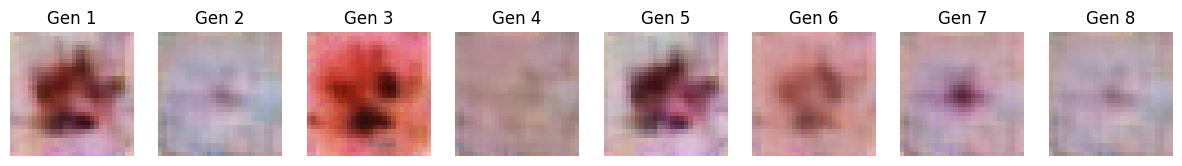

In [22]:
num_gen = 8
z = torch.randn(num_gen, z_dim).to(device)
gen_imgs = G(z).cpu().detach()
gen_imgs = (gen_imgs + 1) / 2  # D√©normaliser [0,1]

fig, axes = plt.subplots(1, num_gen, figsize=(15, 3))
for i in range(num_gen):
    axes[i].imshow(gen_imgs[i].permute(1, 2, 0).numpy())
    axes[i].axis('off')
    axes[i].set_title(f'Gen {i+1}')
plt.show()

## 6. Conclusion et Questions pour la suite

Les SGAN d√©montrent comment la g√©n√©ration adversariale peut enrichir l'apprentissage semi-supervis√© en cr√©ant de la vari√©t√©. Rappel de la strat√©gie : Correction pr√©cise sur √©tiquet√©es (classes 0-6), 'r√©el' sur non √©tiquet√©es (somme 0-6), 'faux' sur g√©n√©r√©es (classe 7). Le g√©n√©rateur trompe D pour am√©liorer les deux.

Si les images g√©n√©r√©es ressemblent √† des l√©sions cutan√©es, le mod√®le a captur√© des motifs utiles ! Comparez les scores : SGAN surpasse-t-il les m√©thodes pr√©c√©dentes ?

**Questions pour r√©fl√©chir :**
1. **Am√©liorations** : Comment rendre le SGAN conditionnel (cSGAN) pour g√©n√©rer par classe ? Utile pour √©quilibrer les minoritaires ?
2. **Stabilit√©** : Les GANs sont instables. Testez avec plus d'√©poques ou WGAN (Wasserstein loss). Qu'observez-vous ?
3. **Hybride** : Combinez SGAN avec pseudo-labeling : utilisez les fausses images comme non √©tiquet√©es suppl√©mentaires.

> **Fin de la d√©mo :** Vous avez vu SGAN en action ! Exp√©rimentez les hyperparam√®tres et comparez. Prochainement : d'autres tech comme les VAEs ou FixMatch.

# P1C6 : La R√©gularisation par Coh√©rence, ou l'art d'√™tre constant avec soi-m√™me

Fini la classification pour aujourd'hui ! On passe √† la **segmentation**. Et pour √ßa, on va utiliser une des techniques les plus puissantes du SSL : la **r√©gularisation par coh√©rence**. Le principe est d'une simplicit√© d√©sarmante : un mod√®le doit donner des pr√©dictions similaires pour la m√™me image, m√™me si celle-ci est vue sous diff√©rents angles (augmentations).

> Si vous reconnaissez votre chat qu'il soit √† l'endroit, √† l'envers ou un peu flou, votre mod√®le devrait en faire autant !

On va impl√©menter une architecture populaire qui utilise cette id√©e : le **Mean Teacher** (le prof moyen). Un mod√®le '√©tudiant' apprend normalement, tandis qu'un mod√®le 'professeur' (plus stable) le guide. Le professeur n'est que la moyenne des poids pass√©s de l'√©tudiant.

**Objectifs du jour :**
1. Changer de t√¢che : passer √† la segmentation sur le dataset `OrganSMNIST`.
2. Mettre en place des pipelines d'augmentations **faibles** et **fortes**.
3. Impl√©menter le mod√®le Mean Teacher.
4. Calculer une perte de supervision (sur les donn√©es √©tiquet√©es) et une perte de coh√©rence (sur les non-√©tiquet√©es).
5. Visualiser les performances via l'√©volution des pertes et le Dice Score.

On va utiliser seulement **20 images √©tiquet√©es** pour simuler un sc√©nario r√©aliste o√π les masques de segmentation sont rares. Pr√™ts pour la d√©mo ?

## 1. Pr√©paration pour la segmentation

On importe les biblioth√®ques n√©cessaires pour la segmentation, notamment des fonctions de perte comme le CrossEntropyLoss (adapt√© pour la segmentation multiclasse) et la librairie d'augmentation `albumentations` pour cr√©er des transformations faibles et fortes.

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

### Chargement du dataset

On utilise `OrganSMNIST` de la biblioth√®que `medmnist`, un dataset de segmentation multi-organes. On s√©lectionne **20 images √©tiquet√©es** pour simuler un sc√©nario semi-supervis√© r√©aliste, o√π les masques sont co√ªteux √† obtenir.

In [24]:
# Custom Dataset class for Kvasir-SEG
class KvasirSegDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_dir = os.path.join(data_dir, 'images')
        self.mask_dir = os.path.join(data_dir, 'masks')
        self.image_files = sorted([f for f in os.listdir(self.image_dir) if f.endswith('.jpg')])
        self.mask_files = sorted([f for f in os.listdir(self.mask_dir) if f.endswith('.jpg')])
        
        # Verify that images and masks match
        assert len(self.image_files) == len(self.mask_files), "Mismatch between images and masks"
        for img_f, mask_f in zip(self.image_files, self.mask_files):
            assert img_f == mask_f, f"Mismatch: {img_f} != {mask_f}"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        
        # Load image and mask
        image = np.array(Image.open(img_path).convert('RGB'))  # Shape: (H, W, 3)
        mask = np.array(Image.open(mask_path).convert('L'))    # Shape: (H, W)
        
        # Ensure mask is binary (0 or 1)
        mask = (mask > 0).astype(np.uint8)  # Convert to binary (0 for background, 1 for polyp)
        
        # Apply transformations if provided
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']
        
        return image, mask

### Augmentations : le bon, la brute et le truand

On d√©finit deux niveaux d'augmentation :
- **Faible (weak)** : pour le `teacher`, avec des transformations l√©g√®res comme des flips horizontaux.
- **Forte (strong)** : pour le `student`, avec des transformations plus agressives (rotation, flou, cutout) pour le pousser √† g√©n√©raliser.

Un dataset custom g√®re ces deux pipelines : les donn√©es √©tiquet√©es re√ßoivent des augmentations fortes, les non √©tiquet√©es re√ßoivent les deux types.

In [25]:
# Augmentation pipelines with resize
IMG_SIZE = (384, 384)  # Fixed size for Kvasir-SEG
weak_transform = A.Compose([
    A.Resize(height=IMG_SIZE[0], width=IMG_SIZE[1], interpolation=1),  # Resize to 384x384
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # RGB normalization
    ToTensorV2()
])

strong_transform = A.Compose([
    A.Resize(height=IMG_SIZE[0], width=IMG_SIZE[1], interpolation=1),  # Resize to 384x384
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(p=0.3),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(height=IMG_SIZE[0], width=IMG_SIZE[1], interpolation=1),  # Resize to 384x384
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # RGB normalization
    ToTensorV2()
])

# Adapted MeanTeacherDataset for Kvasir-SEG
class MeanTeacherDataset(Dataset):
    def __init__(self, dataset, indices, weak_transform, strong_transform, is_labeled=True):
        self.dataset = torch.utils.data.Subset(dataset, indices)
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform
        self.is_labeled = is_labeled

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, mask = self.dataset[idx]
        img = np.asarray(img, dtype=np.uint8)  # Shape: (H, W, 3) or (3, H, W) if tensor
        mask = np.asarray(mask, dtype=np.uint8)  # Shape: (H, W) or (1, H, W) if tensor
        
        # Ensure mask is binary (0 or 1)
        mask = (mask > 0).astype(np.uint8)

        # Check and reshape image to (H, W, 3)
        if isinstance(img, np.ndarray) and len(img.shape) == 3:
            if img.shape[0] == 3:  # Tensor-like (3, H, W)
                img = np.transpose(img, (1, 2, 0))  # Convert to (H, W, 3)
            elif img.shape[2] != 3:  # Invalid channels
                raise ValueError(f"Image at index {idx} has invalid shape {img.shape}, expected (H, W, 3)")
        else:
            raise ValueError(f"Image at index {idx} has invalid shape {img.shape}, expected (H, W, 3)")

        # Check and reshape mask to (H, W)
        if isinstance(mask, np.ndarray):
            if len(mask.shape) == 3:
                if mask.shape[0] == 1:  # Tensor-like (1, H, W)
                    mask = mask.squeeze(0)  # Convert to (H, W)
                elif mask.shape[2] == 1:  # (H, W, 1)
                    mask = mask.squeeze(2)  # Convert to (H, W)
                else:
                    raise ValueError(f"Mask at index {idx} has invalid shape {mask.shape}, expected (H, W)")
            elif len(mask.shape) != 2:
                raise ValueError(f"Mask at index {idx} has invalid shape {mask.shape}, expected (H, W)")

        # Ensure image and mask have the same H, W
        if img.shape[:2] != mask.shape[:2]:
            img = cv2.resize(img, (IMG_SIZE[1], IMG_SIZE[0]), interpolation=cv2.INTER_LINEAR)
            mask = cv2.resize(mask, (IMG_SIZE[1], IMG_SIZE[0]), interpolation=cv2.INTER_NEAREST)

        # Apply augmentations
        if not self.is_labeled:
            transformed_weak = self.weak_transform(image=img, mask=mask)
            transformed_strong = self.strong_transform(image=img, mask=mask)
            return transformed_weak['image'], transformed_strong['image']
        else:
            transformed = self.strong_transform(image=img, mask=mask)
            return transformed['image'], transformed['mask'].long()

/home/quillaur/jupyter_notebooks/.venv/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [26]:

# Configuration du dataset
data_dir = '/home/quillaur/HDD-1TO/datasets/kvasir-seg/Kvasir-SEG'  # Replace with your dataset path
dataset = KvasirSegDataset(data_dir=data_dir, transform=None)  # No transform initially

# Split for SSL demo: 50 labeled, 100 test, rest unlabeled
train_size = len(dataset)
labeled_size = 50
test_size = 100
unlabeled_size = train_size - labeled_size - test_size
labeled_dataset, test_dataset, unlabeled_dataset = random_split(dataset, [labeled_size, test_size, unlabeled_size])

# Assign transform to test_dataset
test_dataset.dataset.transform = test_transform

# DataLoaders for MeanTeacherDataset
labeled_train_dataset = MeanTeacherDataset(dataset, labeled_dataset.indices, weak_transform, strong_transform, is_labeled=True)
unlabeled_train_dataset = MeanTeacherDataset(dataset, unlabeled_dataset.indices, weak_transform, strong_transform, is_labeled=False)

labeled_loader = DataLoader(labeled_train_dataset, batch_size=4, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_train_dataset, batch_size=16, shuffle=True)

# Print number of labeled, unlabeled, and test samples
print(f"Dataset loaded: {len(dataset)} samples | Labeled: {len(labeled_dataset)} | Unlabeled: {len(unlabeled_dataset)} | Test: {len(test_dataset)}")


Dataset loaded: 1000 samples | Labeled: 50 | Unlabeled: 850 | Test: 100


## 2. Le Mod√®le (Student & Teacher)

Pour la segmentation, on utilise une architecture de type U-Net simplifi√©e (pour la d√©mo). On cr√©e **deux instances** : `student` et `teacher`. Le `teacher` est une copie du `student`, mais ses poids sont mis √† jour via une moyenne mobile exponentielle (EMA) pour plus de stabilit√©.

In [27]:
# Device setup: Force CPU
device = torch.device('cpu')
print(f"Using device: {device}")

# Un U-Net tr√®s simple pour l'exemple
def simple_unet(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, 16, 3, padding=1), nn.ReLU(inplace=True),
        nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(inplace=True),
        nn.Conv2d(32, 16, 3, padding=1), nn.ReLU(inplace=True),
        nn.Conv2d(16, out_channels, 1)
    )

def create_models(in_channels, out_channels):
    student = simple_unet(in_channels, out_channels).to(device)
    teacher = simple_unet(in_channels, out_channels).to(device)
    
    # Le teacher ne s'entra√Æne pas par backprop, on g√®le ses poids
    for param in teacher.parameters():
        param.detach_()
        
    return student, teacher

# Cr√©ation des mod√®les
in_channels = 3  # RGB images for Kvasir-SEG
out_channels = 2  # Binary segmentation (polyp vs. background)
student_model, teacher_model = create_models(in_channels, out_channels)
print('Mod√®les Student et Teacher pr√™ts pour la d√©mo !')

Using device: cpu
Mod√®les Student et Teacher pr√™ts pour la d√©mo !


## 3. La boucle d'entra√Ænement Mean Teacher

Voici le c≈ìur de la d√©mo ! √Ä chaque √©poque :
1. Le `student` est entra√Æn√© sur les **donn√©es √©tiquet√©es** avec une perte supervis√©e (CrossEntropyLoss).
2. Les **donn√©es non √©tiquet√©es** passent par le `teacher` (augmentations faibles) et le `student` (augmentations fortes), et on calcule une **perte de coh√©rence** (MSE) entre leurs pr√©dictions softmax.
3. La perte totale combine la perte supervis√©e et la perte de coh√©rence.
4. Le `teacher` est mis √† jour via une moyenne mobile exponentielle (EMA) des poids du `student`.

On affiche les pertes √† chaque √©poque et on trace leur √©volution pour voir la progression.

Entra√Ænement Mean Teacher: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5/5 [03:12<00:00, 38.57s/it]

√âpoque 5/5 - Perte Sup moyenne: 0.4386, Perte Con moyenne: 0.0991


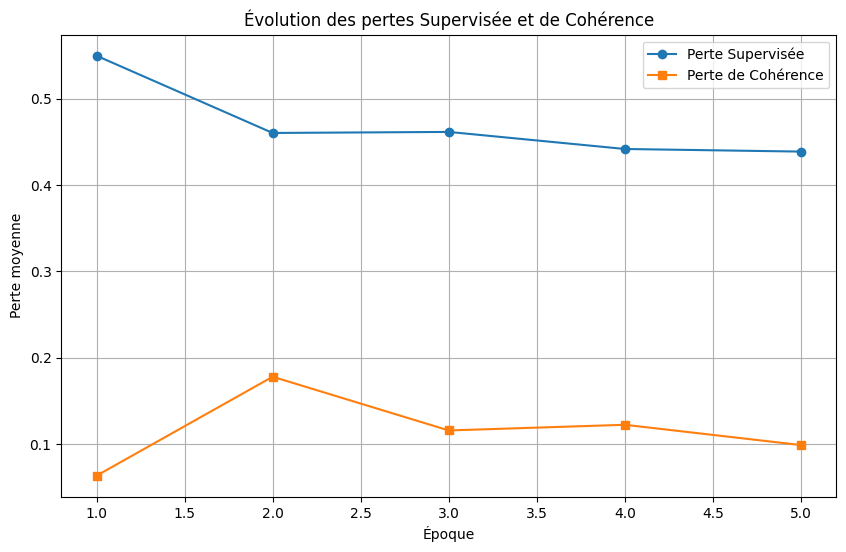

In [28]:

# Fonction pour mettre √† jour le teacher via EMA
def update_teacher_model(student, teacher, alpha=0.99):
    """Mise √† jour des poids du teacher par EMA : teacher = alpha * teacher + (1 - alpha) * student."""
    for teacher_param, student_param in zip(teacher.parameters(), student.parameters()):
        teacher_param.data.mul_(alpha)  # alpha * teacher_param
        teacher_param.data.add_((1 - alpha) * student_param.data)  # + (1 - alpha) * student_param

# Pertes
supervised_criterion = nn.CrossEntropyLoss()
consistency_criterion = nn.MSELoss()

# Optimiseur
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.001)

# Param√®tres d'entra√Ænement
EPOCHS = 5
consistency_weight = 0.1  # Poids de la perte de coh√©rence

# Listes pour stocker les pertes par √©poque
epoch_sup_losses = []
epoch_con_losses = []

for epoch in tqdm(range(EPOCHS), desc='Entra√Ænement Mean Teacher'):
    student_model.train()
    teacher_model.eval()  # Pas de backprop pour the teacher
    sup_losses = []
    con_losses = []
    
    # It√©rer sur les deux loaders
    labeled_iter = iter(labeled_loader)
    unlabeled_iter = iter(unlabeled_loader)
    num_batches = min(len(labeled_loader), len(unlabeled_loader))
    
    for _ in range(num_batches):
        try:
            labeled_imgs, masks = next(labeled_iter)
        except StopIteration:
            labeled_iter = iter(labeled_loader)
            labeled_imgs, masks = next(labeled_iter)
        
        try:
            weak_unlabeled, strong_unlabeled = next(unlabeled_iter)
        except StopIteration:
            unlabeled_iter = iter(unlabeled_loader)
            weak_unlabeled, strong_unlabeled = next(unlabeled_iter)
        
        labeled_imgs, masks = labeled_imgs.to(device), masks.to(device)
        weak_unlabeled, strong_unlabeled = weak_unlabeled.to(device), strong_unlabeled.to(device)
        
        optimizer.zero_grad()
        
        # 1. Perte supervis√©e
        pred_labeled = student_model(labeled_imgs)
        loss_sup = supervised_criterion(pred_labeled, masks)
        
        # 2. Perte de coh√©rence
        with torch.no_grad():
            teacher_preds = teacher_model(weak_unlabeled)
        student_preds = student_model(strong_unlabeled)
        
        # Calculer la perte de coh√©rence sur les probabilit√©s
        loss_con = consistency_criterion(F.softmax(student_preds, dim=1), F.softmax(teacher_preds, dim=1))
        
        # 3. Perte totale
        total_loss = loss_sup + consistency_weight * loss_con
        
        total_loss.backward()
        optimizer.step()
        
        # 4. Mise √† jour du teacher
        update_teacher_model(student_model, teacher_model)
        
        # Stocker les pertes
        sup_losses.append(loss_sup.item())
        con_losses.append(loss_con.item())
    
    # Calculer et stocker les pertes moyennes par √©poque
    epoch_sup_losses.append(np.mean(sup_losses))
    epoch_con_losses.append(np.mean(con_losses))

print(f'√âpoque {epoch+1}/{EPOCHS} - Perte Sup moyenne: {np.mean(sup_losses):.4f}, Perte Con moyenne: {np.mean(con_losses):.4f}')

# Afficher le graphique des pertes
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), epoch_sup_losses, label='Perte Supervis√©e', marker='o')
plt.plot(range(1, EPOCHS + 1), epoch_con_losses, label='Perte de Coh√©rence', marker='s')
plt.xlabel('√âpoque')
plt.ylabel('Perte moyenne')
plt.title('√âvolution des pertes Supervis√©e et de Coh√©rence')
plt.legend()
plt.grid(True)
plt.show()

## 4. √âvaluation

On √©value le `teacher_model` (plus stable gr√¢ce √† l'EMA) sur le jeu de test avec le **Dice Score**, une m√©trique cl√© en segmentation. On s'attend √† ce que la r√©gularisation par coh√©rence am√©liore les performances par rapport √† un mod√®le entra√Æn√© uniquement sur les 20 images √©tiquet√©es.

In [29]:

# Fonction pour calculer le Dice score (adapted for binary segmentation)
def dice_score(pred, target, smooth=1e-8):
    pred = F.softmax(pred, dim=1)[:, 1, :, :]  # Probability for polyp class (1)
    target = target.float()  # Binary mask (0 or 1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

# Evaluation on test set
teacher_model.eval()
total_dice = 0
test_loader_eval = DataLoader(test_dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    for images, masks in test_loader_eval:
        images, masks = images.to(device), masks.to(device)
        outputs = teacher_model(images)
        total_dice += dice_score(outputs, masks).item()

avg_dice = total_dice / len(test_loader_eval)
print(f'Dice Score moyen sur le jeu de test : {avg_dice:.3f}')


Dice Score moyen sur le jeu de test : 0.255


## 5. Visualisation des pr√©dictions

Pour mieux comprendre les performances, visualisons quelques pr√©dictions du `teacher_model` sur le jeu de test, avec les images, les masques ground truth, et les masques pr√©dits.

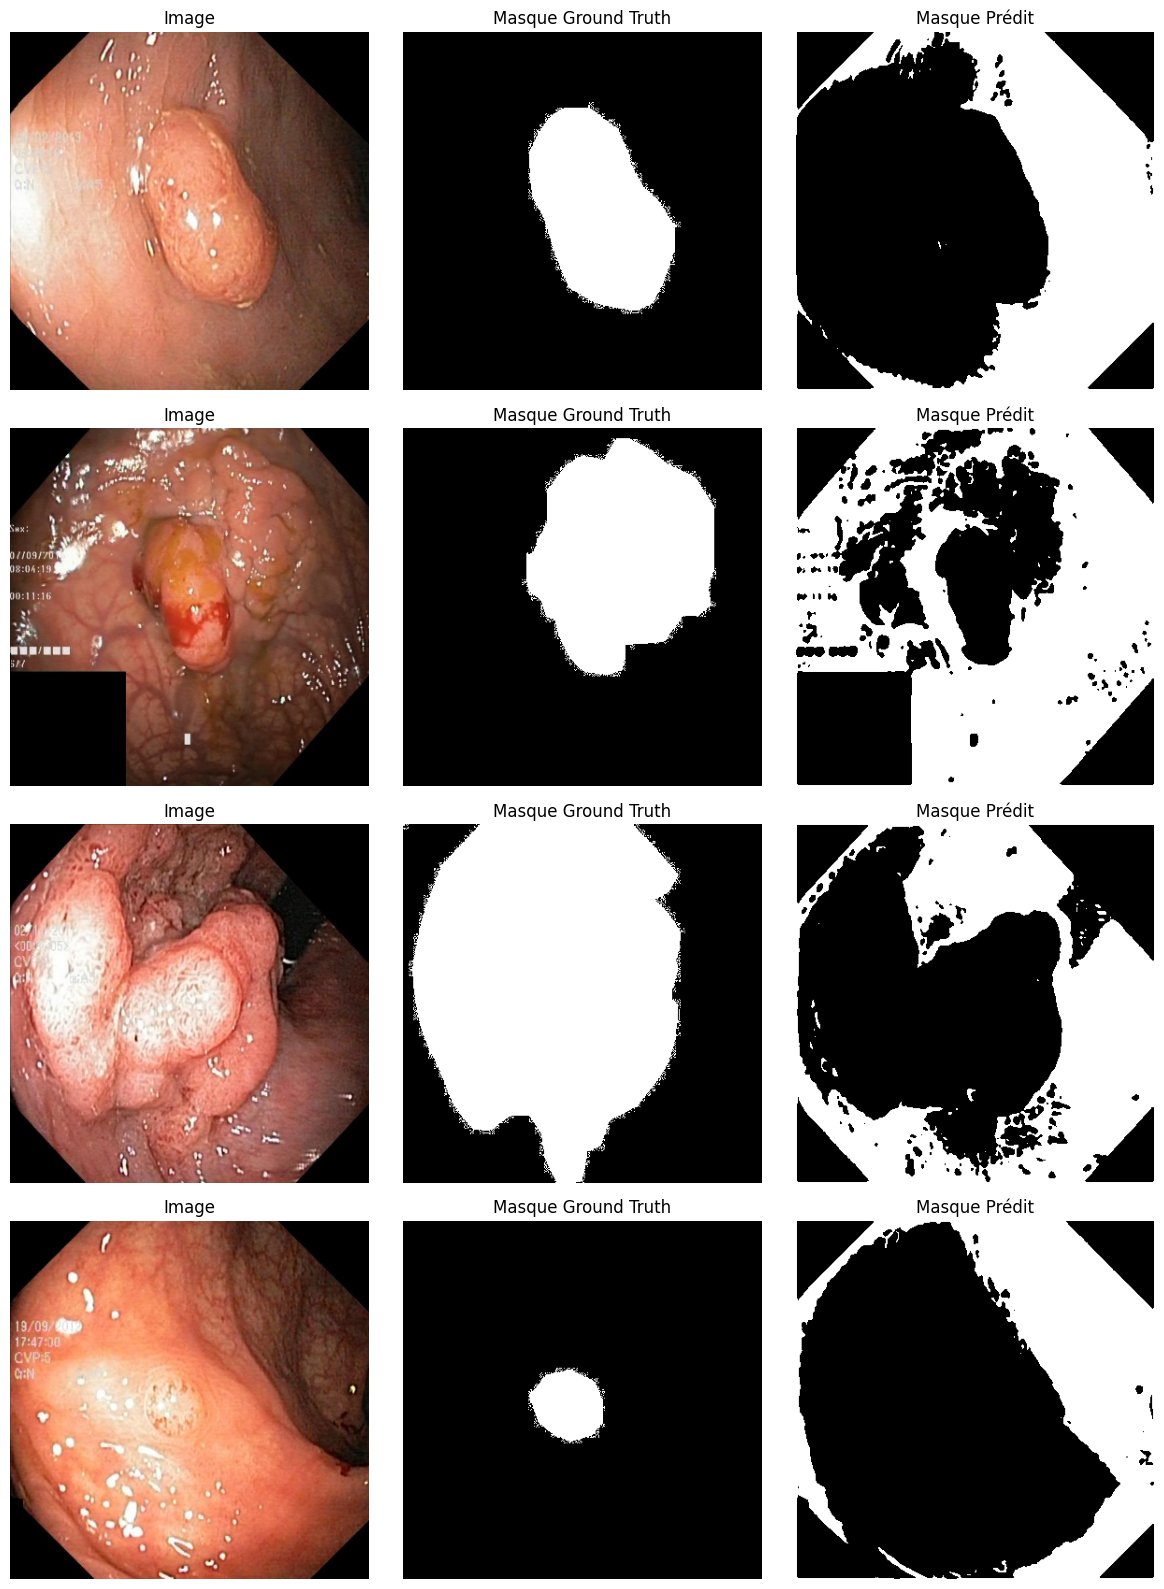

In [30]:

# Visualiser quelques pr√©dictions
num_examples = 4
test_subset = Subset(test_dataset, range(num_examples))
test_loader_viz = DataLoader(test_subset, batch_size=num_examples, shuffle=False)

teacher_model.eval()
with torch.no_grad():
    images, masks = next(iter(test_loader_viz))
    images, masks = images.to(device), masks.to(device)
    outputs = teacher_model(images)
    preds = F.softmax(outputs, dim=1).argmax(dim=1).cpu().numpy()
    images = images.cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5  # Denormalize RGB
    masks = masks.cpu().numpy()

fig, axes = plt.subplots(num_examples, 3, figsize=(12, 4 * num_examples))
for i in range(num_examples):
    axes[i, 0].imshow(images[i])
    axes[i, 0].set_title('Image')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(masks[i], cmap='gray')
    axes[i, 1].set_title('Masque Ground Truth')
    axes[i, 1].axis('off')
    axes[i, 2].imshow(preds[i], cmap='gray')
    axes[i, 2].set_title('Masque Pr√©dit')
    axes[i, 2].axis('off')
plt.tight_layout()
plt.show()

## 6. Questions de R√©flexion

La d√©mo montre comment le Mean Teacher exploite les donn√©es non √©tiquet√©es via la r√©gularisation par coh√©rence. Observez les courbes de pertes : la perte de coh√©rence diminue-t-elle, signe que le `student` devient coh√©rent avec le `teacher` ? Le Dice Score est-il comp√©titif pour seulement 20 images √©tiquet√©es ?

**Questions pour r√©fl√©chir :**
1. **Le r√¥le de `alpha`** : Le coefficient d'EMA `alpha=0.99` rend le `teacher` stable. Que se passerait-il avec un `alpha` faible (ex: 0.5) ? Testez pour voir !
2. **Augmentations fortes vs. faibles** : Pourquoi les augmentations fortes pour le `student` sont-elles cruciales ? Que se passe-t-il si on utilise les m√™mes augmentations pour les deux ?
3. **Ramp-up de la perte de coh√©rence** : La perte de coh√©rence est-elle utile d√®s le d√©but, quand le mod√®le est peu entra√Æn√© ? Essayez un `consistency_weight` qui augmente progressivement (ex: de 0 √† 0.1 sur 10 √©poques).

> **Le mot de la fin :** Le Mean Teacher combine pseudo-labeling (les pr√©dictions du `teacher` comme pseudo-labels) et r√©gularisation par coh√©rence. Dans le prochain chapitre, on explorera des m√©thodes comme FixMatch pour pousser encore plus loin !

# P1C7 : Advanced SSL Techniques - FixMatch, FlexMatch, and MixMatch

Welcome to the advanced chapter of our SSL journey! We've explored pseudo-labeling and consistency regularization earlier. Now, let's dive into cutting-edge techniques: **FixMatch**, **FlexMatch**, and **MixMatch**. These methods combine the best of pseudo-labeling and consistency to tackle datasets with limited labels, like `DermaMNIST`.

> Think of this as upgrading your SSL toolkit with turbocharged algorithms!

**Core Principles:**
- **FixMatch**: Uses weak and strong augmentations with a confidence threshold for pseudo-labels.
- **FlexMatch**: Enhances FixMatch with dynamic thresholding per class, ideal for imbalanced data.
- **MixMatch**: Adds data mixing (e.g., MixUp) to improve robustness by blending labeled and unlabeled samples.

**Objectives:**
1. Return to `DermaMNIST` classification with 100 labeled images.
2. Implement FixMatch, FlexMatch, and MixMatch.
3. Compare results to baseline methods to showcase SSL advancements.


## 1. Preparation (The Usual Setup)

Let‚Äôs set up our environment for `DermaMNIST` classification. We‚Äôll use 100 labeled images and leverage Albumentations for controlled augmentations.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
import medmnist
from medmnist import INFO, Evaluator
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [32]:
# Load DermaMNIST data
data_flag = 'dermamnist'
info = INFO[data_flag]
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

train_dataset = DataClass(split='train', download=True)
test_dataset = DataClass(split='test', transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[.5], std=[.5])]), download=True)

# Split into labeled (100) and unlabeled sets
all_indices = list(range(len(train_dataset)))
labels_array = np.array(train_dataset.labels).flatten()
labeled_indices, unlabeled_indices = train_test_split(all_indices, train_size=500, random_state=42, stratify=labels_array)

print(f'Labeled data: {len(labeled_indices)}, Unlabeled data: {len(unlabeled_indices)}')

Labeled data: 500, Unlabeled data: 6507


### Weak and Strong Augmentations

We need two augmentation pipelines: weak for pseudo-label generation and strong for training robustness.

In [33]:

# Define weak and strong augmentations for single-channel images
weak_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2(transpose_mask=True)  # Preserve 1 channel
])

strong_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(p=0.3),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2(transpose_mask=True)  # Preserve 1 channel
])
print("Transforms initialized")

# Custom datasets for FixMatch
class FixMatchDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, transform):
        self.dataset = Subset(dataset, indices)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img = np.array(img)  # Ensure img is [H, W] (single-channel)
        transformed = self.transform(image=img)
        return transformed['image'], torch.tensor(label).long()

class FixMatchUnlabeledDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, weak_transform, strong_transform):
        self.dataset = Subset(dataset, indices)
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        img = np.array(img)  # Ensure img is [H, W] (single-channel)
        weak = self.weak_transform(image=img)['image']
        strong = self.strong_transform(image=img)['image']
        return weak, strong

Transforms initialized


/home/quillaur/jupyter_notebooks/.venv/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


## 2. Models and Training Loops

We‚Äôll use a simple CNN and implement three training loops: FixMatch, FlexMatch, and MixMatch.

In [34]:

# Define the SimpleCNN model for single-channel input
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2))
        self.fc = nn.Linear(7 * 7 * 32, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        return self.fc(out)

# Initialize model, optimizer, and loss functions
model = SimpleCNN(in_channels=3, num_classes=n_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

supervised_criterion = nn.CrossEntropyLoss()
unsupervised_criterion = nn.CrossEntropyLoss(reduction='none')

### 2.1 FixMatch Training Loop

Let‚Äôs implement the FixMatch algorithm step-by-step.

**Instructions:**
1. Compute supervised loss on labeled data.
2. Generate pseudo-labels: Predict on weak augmentations, compute probabilities, and create a mask for confident predictions (threshold = 0.95).
3. Compute unsupervised loss: Predict on strong augmentations and apply the mask to confident pseudo-labels.
4. Combine losses and backpropagate.

In [35]:

# Create DataLoaders
labeled_dataset = FixMatchDataset(train_dataset, labeled_indices, strong_transform)
unlabeled_dataset = FixMatchUnlabeledDataset(train_dataset, unlabeled_indices, weak_transform, strong_transform)
print(f"Datasets created: labeled={len(labeled_dataset)}, unlabeled={len(unlabeled_dataset)}")

labeled_loader = DataLoader(labeled_dataset, batch_size=16, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=64, shuffle=True)
print(f"Dataloaders ready: batches labeled={len(labeled_loader)}, unlabeled={len(unlabeled_loader)}")

print("Starting training loop")
# FixMatch training as a function (to unify with other methods)
def train_fixmatch(model, labeled_loader, unlabeled_loader, epochs=30, threshold=0.95, unsupervised_weight=1.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
    sup_crit = nn.CrossEntropyLoss()
    unsup_crit = nn.CrossEntropyLoss(reduction='none')
    for epoch in tqdm(range(epochs), desc='Training FixMatch'):
        model.train()
        batch_iterator = zip(labeled_loader, unlabeled_loader)
        for (labeled_imgs, labels), (weak_unlabeled, strong_unlabeled) in batch_iterator:
            optimizer.zero_grad()
            # Supervised loss
            logits_sup = model(labeled_imgs)
            loss_sup = sup_crit(logits_sup, labels.squeeze())
            # Pseudo-labels from weak
            with torch.no_grad():
                logits_weak = model(weak_unlabeled)
                probs = F.softmax(logits_weak, dim=1)
                max_probs, pseudo_labels = torch.max(probs, dim=1)
                mask = max_probs.ge(threshold).float()
            # Unsupervised on strong
            logits_strong = model(strong_unlabeled)
            loss_unsup_raw = unsup_crit(logits_strong, pseudo_labels)
            loss_unsup = (loss_unsup_raw * mask).mean()
            # Total
            total_loss = loss_sup + unsupervised_weight * loss_unsup
            total_loss.backward()
            optimizer.step()
    return model

Datasets created: labeled=500, unlabeled=6507
Dataloaders ready: batches labeled=32, unlabeled=102
Starting training loop


In [36]:

EPOCHS = 50
THRESHOLD = 0.95
UNSUPERVISED_WEIGHT = 1.0

print("Starting FixMatch training...")
fix_model = SimpleCNN(in_channels=3, num_classes=n_classes)
fix_model = train_fixmatch(fix_model, labeled_loader, unlabeled_loader, epochs=EPOCHS, threshold=THRESHOLD, unsupervised_weight=UNSUPERVISED_WEIGHT)


Starting FixMatch training...


Training FixMatch: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 50/50 [01:28<00:00,  1.78s/it]


### 2.2 FlexMatch Training Loop

FlexMatch adapts the threshold dynamically per class to handle imbalanced datasets.

**Instructions:**
1. Compute supervised loss as before.
2. Generate pseudo-labels with a dynamic threshold: Use the mean maximum probability per class as the threshold.
3. Compute unsupervised loss with the dynamic mask.
4. Combine and backpropagate.

In [37]:

def train_flexmatch(model, labeled_loader, unlabeled_loader, epochs=20, threshold=0.95, unsupervised_weight=1.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
    sup_crit = nn.CrossEntropyLoss()
    unsup_crit = nn.CrossEntropyLoss(reduction='none')
    ema_conf = torch.full((n_classes,), 0.7)
    ema_m = 0.9
    for epoch in tqdm(range(epochs), desc='Training FlexMatch'):
        model.train()
        for (labeled_imgs, labels), (weak_unlabeled, strong_unlabeled) in zip(labeled_loader, unlabeled_loader):
            optimizer.zero_grad()
            # Supervised
            logits_sup = model(labeled_imgs)
            loss_sup = sup_crit(logits_sup, labels.squeeze())
            # Weak preds
            with torch.no_grad():
                logits_weak = model(weak_unlabeled)
                probs = F.softmax(logits_weak, dim=1)
                max_probs, pseudo_labels = torch.max(probs, dim=1)
                # Update class-wise EMA confidence using samples of each predicted class
                for k in range(n_classes):
                    mask_k = (pseudo_labels == k)
                    if mask_k.any():
                        conf_k = max_probs[mask_k].mean()
                        ema_conf[k] = ema_m * ema_conf[k] + (1 - ema_m) * conf_k
                # Class-wise dynamic thresholds
                max_ema = torch.clamp(ema_conf.max(), min=1e-6)
                tau_k = threshold * (max_ema / torch.clamp(ema_conf, min=1e-6))
                eff_thresh = tau_k[pseudo_labels]
                mask = max_probs.ge(eff_thresh).float()
            # Unsupervised loss on strong views
            logits_strong = model(strong_unlabeled)
            loss_unsup_raw = unsup_crit(logits_strong, pseudo_labels)
            loss_unsup = (loss_unsup_raw * mask).mean()
            # Total
            total_loss = loss_sup + unsupervised_weight * loss_unsup
            total_loss.backward()
            optimizer.step()
    return model

In [38]:
# Train and evaluate FlexMatch
print("Starting FlexMatch training...")
flex_model = SimpleCNN(in_channels=3, num_classes=n_classes)
flex_model = train_flexmatch(flex_model, labeled_loader, unlabeled_loader, epochs=EPOCHS, threshold=THRESHOLD, unsupervised_weight=UNSUPERVISED_WEIGHT)

Starting FlexMatch training...


Training FlexMatch: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 50/50 [01:26<00:00,  1.73s/it]


### 2.3 MixMatch Training Loop

MixMatch combines labeled and unlabeled data using MixUp and sharpening.

**Instructions:**
1. Compute supervised loss on labeled data.
2. Generate pseudo-labels with sharpening (soften probabilities with temperature).
3. Mix labeled and unlabeled data using MixUp.
4. Compute unsupervised loss on mixed data.
5. Combine and backpropagate.

In [45]:
def one_hot(labels, num_classes):
    y = torch.zeros(labels.size(0), num_classes, device=labels.device)
    return y.scatter_(1, labels.view(-1, 1).long(), 1)

def sharpen(p, T=0.5):
    p_power = p ** (1.0 / T)
    return p_power / p_power.sum(dim=1, keepdim=True)

def soft_cross_entropy(logits, soft_targets):
    log_probs = F.log_softmax(logits, dim=1)
    return -(soft_targets * log_probs).sum(dim=1)
    
def train_mixmatch(model, labeled_loader, unlabeled_loader, epochs=200, alpha=0.75, T=0.5, lambda_u=100.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
    for epoch in tqdm(range(epochs), desc='Training MixMatch'):
        model.train()
        for (labeled_imgs, labels), (u_imgs_w, _) in zip(labeled_loader, unlabeled_loader):
            b_l = labeled_imgs.size(0)
            b_u = u_imgs_w.size(0)
            # Guess labels for unlabeled
            with torch.no_grad():
                logits_u = model(u_imgs_w)
                probs_u = F.softmax(logits_u, dim=1)
                q_u = sharpen(probs_u, T)
            # One-hot for labeled
            y_l = one_hot(labels.squeeze(), n_classes)
            # Concatenate
            X = torch.cat([labeled_imgs, u_imgs_w], dim=0)
            Y = torch.cat([y_l, q_u], dim=0)
            # MixUp
            idx = torch.randperm(X.size(0))
            lam = np.random.beta(alpha, alpha)
            lam = max(lam, 1 - lam)
            X_mixed = lam * X + (1 - lam) * X[idx]
            Y_mixed = lam * Y + (1 - lam) * Y[idx]
            # Forward
            logits = model(X_mixed)
            # Losses
            loss_sup = soft_cross_entropy(logits[:b_l], Y_mixed[:b_l]).mean()
            probs_mixed = F.softmax(logits[b_l:], dim=1)
            loss_unsup = F.mse_loss(probs_mixed, Y_mixed[b_l:])
            loss = loss_sup + lambda_u * loss_unsup
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model

In [46]:
# Train and evaluate MixMatch
print("Starting MixMatch training...")
mix_model = SimpleCNN(in_channels=3, num_classes=n_classes)
mix_model = train_mixmatch(mix_model, labeled_loader, unlabeled_loader, epochs=EPOCHS, alpha=0.75, T=0.5, lambda_u=50.0)


Starting MixMatch training...


Training MixMatch: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 50/50 [01:14<00:00,  1.49s/it]


## 3. Final Evaluation and Retrospective

Let‚Äôs evaluate all models and compare their performance.

In [47]:
@torch.no_grad()
def evaluate_model(model, test_dataset, data_flag):
    model.eval()
    y_true = torch.tensor([])
    y_score_logits = torch.tensor([])
    y_score_preds = torch.tensor([])
    test_loader = DataLoader(test_dataset, batch_size=128)
    for images, labels in test_loader:
        outputs = model(images)
        y_true = torch.cat((y_true, labels), 0)
        y_score_logits = torch.cat((y_score_logits, outputs), 0)
        preds = torch.argmax(outputs, dim=1)
        y_score_preds = torch.cat((y_score_preds, preds), 0)
    y_true_np = y_true.squeeze().cpu().numpy()
    y_score_logits_np = y_score_logits.detach().cpu().numpy()
    y_score_preds_np = y_score_preds.detach().cpu().numpy()
    evaluator = Evaluator(data_flag, 'test')
    metrics = evaluator.evaluate(y_score_logits_np)
    f1_macro = f1_score(y_true_np, y_score_preds_np, average='macro')
    f1_weighted = f1_score(y_true_np, y_score_preds_np, average='weighted')
    return metrics[0], metrics[1], f1_macro, f1_weighted

In [48]:
# Consolidated Evaluation
print("Starting consolidated evaluation for FixMatch, FlexMatch, and MixMatch...")
results = []
for name, mdl in [("FixMatch", fix_model), ("FlexMatch", flex_model), ("MixMatch", mix_model)]:
    auc, acc, f1_macro, f1_weighted = evaluate_model(mdl, test_dataset, data_flag)
    results.append((name, auc, acc, f1_macro, f1_weighted))
    print(f"--- {name} Results ---")
    print(f"AUC: {auc:.3f}, Accuracy: {acc:.3f}, F1(macro): {f1_macro:.3f}, F1(weighted): {f1_weighted:.3f}")

Starting consolidated evaluation for FixMatch, FlexMatch, and MixMatch...
--- FixMatch Results ---
AUC: 0.801, Accuracy: 0.688, F1(macro): 0.319, F1(weighted): 0.656
--- FlexMatch Results ---
AUC: 0.809, Accuracy: 0.667, F1(macro): 0.336, F1(weighted): 0.658
--- MixMatch Results ---
AUC: 0.799, Accuracy: 0.671, F1(macro): 0.150, F1(weighted): 0.542


## 4. Conclusion and Reflection

Congratulations on mastering advanced SSL techniques!

**Recap of Results (Fill in your scores):**
- **Baseline (Supervised only)**: AUC = ?, Acc = ?
- **P1C3 (Pseudo-Labeling)**: AUC = ?, Acc = ?
- **P1C4 (Label Spreading)**: Acc = ?
- **P1C5 (SGAN)**: AUC = ?, Acc = ?
- **P1C7 (FixMatch)**: AUC = ?, Acc = ?
- **P1C7 (FlexMatch)**: AUC = ?, Acc = ?
- **P1C7 (MixMatch)**: AUC = ?, Acc = ?

You should see a clear progression, highlighting SSL's power.

**Reflection Questions:**
1. **FlexMatch Advantage**: Why does dynamic thresholding in FlexMatch help with imbalanced datasets like `DermaMNIST`?
2. **MixMatch Innovation**: How does MixUp in MixMatch improve over FixMatch‚Äôs approach, especially with limited labeled data?
3. **Next Steps**: Self-supervised learning (e.g., SimCLR, MAE) pre-trains models on unlabeled data. How might this enhance your SSL pipeline?

> **Final Thought**: With these techniques, you can tackle data-scarce problems intelligently. The key is leveraging unlabeled data effectively!